**This notebook aims to present the Qolmat repo through an example of a multivariate time series.
In Qolmat, a few data imputation methods are implemented as well as a way to evaluate their performance.**

First, import some useful librairies

In [225]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import scipy
np.random.seed(100)
import pprint
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
sns.set_context("paper")
sns.set_theme(style="ticks")
from typing import Optional

# models for imputations
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, HistGradientBoostingRegressor


import sys
sys.path.append("../../")
from qolmat.benchmark import comparator
from qolmat.imputations import models
from qolmat.utils import data, utils
from qolmat.imputations.em_sampler import ImputeEM


In [228]:
def display_bar_table(data: pd.DataFrame, ylabel: Optional[str]="", path: Optional[str]=None):

    colors = plt.cm.YlGnBu(np.linspace(0.2, 0.8, len(data)))

    data.T.plot(
        x=data.T.index.name,
        kind='bar',
        stacked=False,
        color=colors)
    sns.despine()

    plt.table(cellText=np.around(data.values,4),
                        rowLabels=data.index,
                        rowColours=colors,
                        colLabels=data.columns,
                        bbox=[1.5,0,1.6,1])

    plt.xticks(fontsize=14)
    plt.ylabel(f"{ylabel}", fontsize=14)
    sns.despine()

    if path:
        plt.savefig(f"{path}.png", transparent=True)
    plt.show()

### **I. Load data**

The data used in this example is the Beijing Multi-Site Air-Quality Data Set. It consists in hourly air pollutants data from 12 chinese nationally-controlled air-quality monitoring sites and is available at https://archive.ics.uci.edu/ml/machine-learning-databases/00501/.
This dataset only contains numerical vairables.

In [81]:
download = True
dataset = data.get_data(download=download)
if download:
    cols_to_impute = ["TEMP", "PRES", "DEWP"]
else:
    cols_to_impute = ["var"]

dataset.reset_index(inplace=True)
dataset.set_index(["station", "datetime"], inplace=True)
dataset.head()

PM2.5        PM10        SO2        NO2           CO  \
station datetime                                                                
Gucheng 2013-03-01    8.625000   16.875000   7.391304  14.250000   869.565217   
        2013-03-02   36.916667   51.375000  37.291667  37.565217  1479.041667   
        2013-03-03   80.333333  120.041667  47.541667  63.333333  2349.708333   
        2013-03-04   26.500000   51.291667  18.666667  32.666667  1170.666667   
        2013-03-05  136.708333  172.541667  75.130435  73.500000  1381.545455   

                           O3      TEMP         PRES       DEWP  RAIN  \
station datetime                                                        
Gucheng 2013-03-01  77.130435  1.691667  1024.816667 -19.691667   0.0   
        2013-03-02  39.583333  0.820833  1024.900000 -16.337500   0.0   
        2013-03-03  33.708333  6.562500  1012.566667 -11.991667   0.0   
        2013-03-04  67.250000  9.795833  1015.608333 -11.945833   0.0   
        2013-03-05  84.375000  6.750000  1008.883333  -7.741667   0.0   

                        WSPM  
station datetime              
Gucheng 2013-03-01  2.350000  
        2013-03-02  1.087500  
        2013-03-03  1.400000  
        2013-03-04  1.541667  
        2013-03-05  0.841667

Let's take a look at variables to impute. We only consider a station, Aotizhongxin. 
Time series display seasonalities (roughly 12 months).

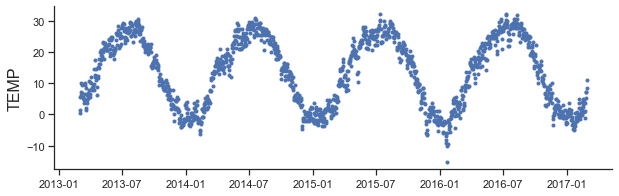

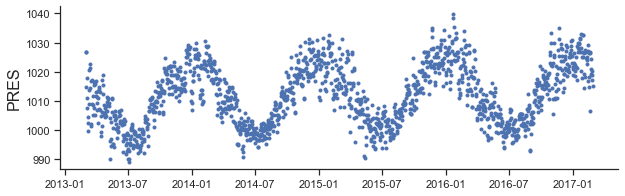

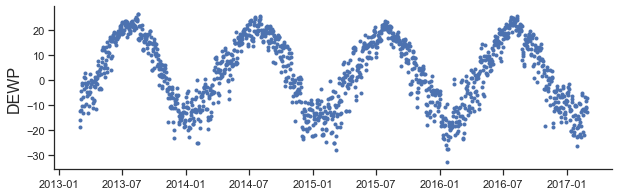

In [82]:
for col in cols_to_impute:
    plt.figure(figsize=(10, 3))
    for station, df in dataset.groupby("station"):
        plt.plot(df.reset_index().datetime, df[col], '.', label=station)
        break
    plt.ylabel(col, fontsize=16)
    sns.despine()
    plt.show()

### **II. Corruption**

We here create some artificial missing data. 
For the temp and pres variables, we create them randomly. More precisely, each entry has a probability p to be missing.
For the dewp variable, missing values depend on the month. If the month is even, then the data is missing.
In this way, different patterns of missign data are created. However, note this is nothing but a kind example since there is no correlation in the missing patterns.

In [83]:
df_corrupted = df[cols_to_impute].copy()

mask_temp = np.random.choice(a=[False, True], size=(len(df_corrupted),), p=[0.30, 0.70])
mask_pres = np.random.choice(a=[False, True], size=(len(df_corrupted),), p=[0.35, 0.65])
mask_dewp = (df_corrupted.index.get_level_values(1).month % 2 == 0)

df_corrupted.loc[mask_temp, "TEMP"] = np.nan
df_corrupted.loc[mask_pres, "PRES"] = np.nan
df_corrupted.loc[mask_dewp, "DEWP"] = np.nan

df_corrupted.head()

TEMP      PRES       DEWP
station      datetime                                 
Aotizhongxin 2013-03-01       NaN  1026.875 -18.745833
             2013-03-02  0.616667       NaN -15.937500
             2013-03-03       NaN       NaN -12.316667
             2013-03-04       NaN       NaN -11.683333
             2013-03-05  6.291667       NaN  -7.525000

We can inspect visually the missing data.

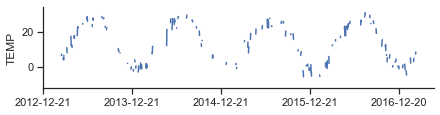

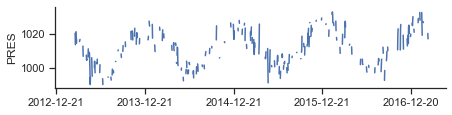

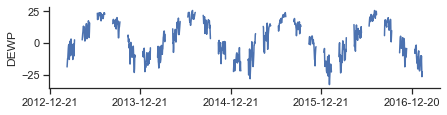

In [84]:
for col in cols_to_impute:
    fig, ax = plt.subplots(figsize=(7, 1.5))    
    for station, df in dataset.groupby("station"):
        plt.plot(df.reset_index().datetime, df_corrupted[col], '-', label=station)
        break
    plt.ylabel(col, fontsize=12)
    loc = plticker.MultipleLocator(base=365) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(loc)
    sns.despine()
    plt.show()

### **III. Imputation methods**

This part is devoted to the imputation methods. The idea is to try different algorithms and compare them. 

<u>**Methods**</u>:
There are two kinds of methods. The first one is not specific to multivariate time series, as for instance ImputeByMean: columns with missing values are imputed separetaly, i.e. possible correlations are not taken into account. The second one is specific to multivariate time series, where other columns are needed to impute another. 

For the ImputeByMean or ImputeByMedian, the user is allow to specify a list of variables indicating how the groupby will be made, to impute the data. More precisely, data are first grouped and then the mean or median of each group is computed. The missign values are then imputed by the corresponding mean or median. If nothing is passed, then the mean or median of each column is used as value to impute.

The ImputeOnResiduals method procedes in 3 steps. First, time series are decomposed (seasonality, trend and residuals). Then the residuals are imputed thanks to a interpolation method. And finally, time series are recomposed. 

For more information about the methods, we invite you to read the docs. 

<u>**Hyperparameters' search**</u>:
Some methods require hyperparameters. The user can directly specify them, or he can procede to a search. To do so, he has to define a search_params dictionary, where keys are the imputation method's name and the values are a dictionary specifyign the minimum, maximum or list of categories and type of values (Integer, Real or Category) to search. 
In pratice, we rely on a cross validation to find the best hyperparams values minimising an error reconstruction.

In [98]:
imputer_mean = models.ImputeByMean(["datetime.dt.month", "datetime.dt.dayofweek"])
imputer_median = models.ImputeByMedian(["datetime.dt.month", "datetime.dt.dayofweek"]) #, "datetime.dt.round('10min')"])
imputer_interpol = models.ImputeByInterpolation(method="linear")
imputer_random = models.RandomImpute()
imputer_residuals = models.ImputeOnResiduals("additive", 7, "freq", "linear")
imputer_kalman = models.ImputeKalman(0, 1)
imputer_rpca = models.ImputeRPCA(
  method="temporal", multivariate=False, **{"n_rows":7*4, "maxIter":1000, "tau":1.2, "lam":0.81}
  )
imputer_em = ImputeEM(n_iter_em=14, n_iter_ou=10, verbose=0, strategy="argmax", temporal=False)
imputer_spline = models.ImputeBySpline()
imputer_locf = models.ImputeLOCF()
imputer_nocb = models.ImputeNOCB()
imputer_knn = models.ImputeKNN(k=10)
imputer_iterative = models.ImputeIterative(
  **{"estimator": LinearRegression(), "sample_posterior": False, "max_iter": 100, "missing_values": np.nan}
  )
impute_regressor = models.ImputeRegressor(
  HistGradientBoostingRegressor(), cols_to_impute=cols_to_impute
)
impute_stochastic_regressor = models.ImputeStochasticRegressor(
  HistGradientBoostingRegressor(), cols_to_impute=cols_to_impute
)
impute_mfe = models.ImputeMissForest()

dict_models = {
    "interpolation": imputer_interpol,
    "residuals": imputer_residuals,
    # "kalman": imputer_kalman,
    "EM": imputer_em,
    "RPCA": imputer_rpca,
    # "KNN": imputer_knn,
    # "MFE": impute_mfe,
}


search_params = {
  # "ImputeKNN": {"k": {"min":2, "max":3, "type":"Integer"}},
  # "ImputeRPCA": {
  #   "lam": {"min": 0.5, "max": 1, "type":"Real"},
  #   "tau": {"min": 1, "max": 1.5, "type":"Real"},
  # }
}
  
prop_nan = 0.05
filter_value_nan = 0

In order to compare the methods, we $i)$ artificially and randomly create missing data; $ii)$ then impute it using the different methods chosen and $iii)$ calculate the reconstruction error. These three steps are repeated a cv number of times. For each method, we calculate the average error and compare the final errors. 

<p align="center">
    <img src="../../docs/images/comparator.png"  width=50% height=50%>
</p>

Concretely, the comparator takes as input a dataframe to impute, a proportion of nan to create, a dictionary of models (those previously mentioned), a list with the columns names to impute, the number of articially corrupted dataframe to create: n_samples, the search dictionary search_params, and possibly a threshold for filter the nan value. 

Then, it suffices to use the compare function to obtain the results: a dataframe with different metrics. 
This allows an easy comparison of the different imputations. 

Note these metrics compute reconstruction errors; it tells nothing about the distances between the "true" and "imputed" distributions.

In [99]:
comparison = comparator.Comparator(
    df_corrupted,
    prop_nan, 
    dict_models, 
    cols_to_impute,
    n_samples=4,
    search_params=search_params,
    filter_value_nan=filter_value_nan,
)
results = comparison.compare()
results

ImputeByInterpolation
ImputeOnResiduals
ImputeEM
ImputeRPCA


/Users/hlbotterman/virtualEnv/env_qolmat/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/hlbotterman/virtualEnv/env_qolmat/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/hlbotterman/virtualEnv/env_qolmat/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/Users/hlbotterman/virtualEnv/env_qolmat/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


ImputeMissForest
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


,interpolation,residuals,EM,RPCA,MFE
rmse,29.536450,33.690900,30.219900,40.743650,87.47905
mae,191.725825,229.817275,207.248175,299.186425,645.49755
wmape,0.100275,0.118300,0.113375,0.165000,0.43730


### **IV. Comparison of methods**

We now run just one time each algorithm on the initial corrupted dataframe and compare the different performances through multiple analysis.

In [100]:
dfs_imputed = {name: imp.fit_transform(df_corrupted) for name, imp in dict_models.items()}

/Users/hlbotterman/virtualEnv/env_qolmat/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


Let's look at the imputations.
When the data is missing at random, imputation is easier. Missing block are more challenging. 
Note here the RPCA method does not worl on the third variabel since the notion of incoherence is violated.

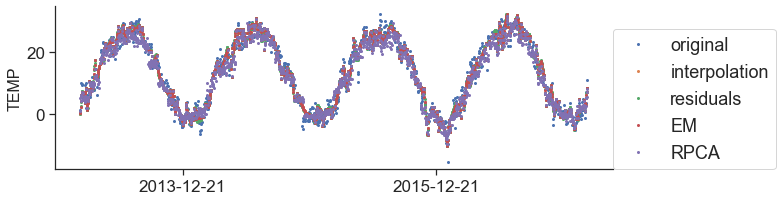

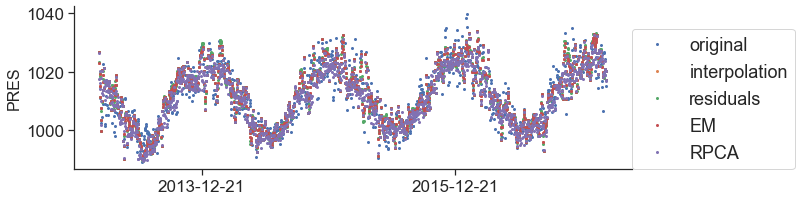

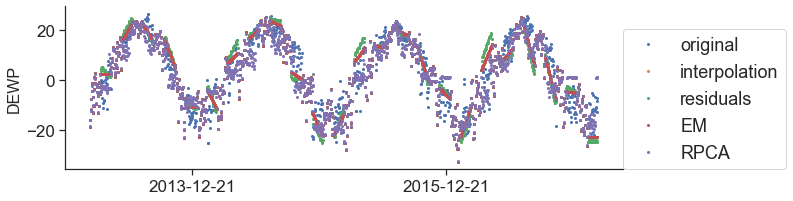

In [88]:
city = "Aotizhongxin"
for col in cols_to_impute:
    fig, ax = plt.subplots(figsize=(10, 3))
    df = dataset.loc[city]
    
    plt.plot(df[col], ".", ms=4, label="original")
    for name, model in list(dict_models.items()):
        plt.plot(dfs_imputed[name].loc[city][col], '.', ms=4, label=name)
    plt.ylabel(col, fontsize=16)
    plt.legend(loc=[1, 0], fontsize=18)
    loc = plticker.MultipleLocator(base=2*365)
    ax.xaxis.set_major_locator(loc)
    ax.tick_params(axis='both', which='major', labelsize=17)
    sns.despine()
    plt.show()

**IV.a. Covariance**

We first check the covariance. We simply plot one variable versus one another. 
One observes the methods provide similar visual resuls: it's difficult to compare them based on this criterion.

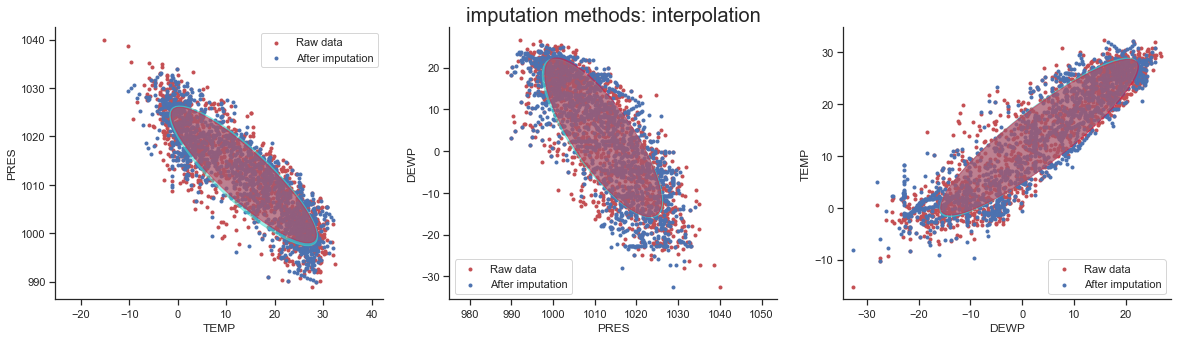

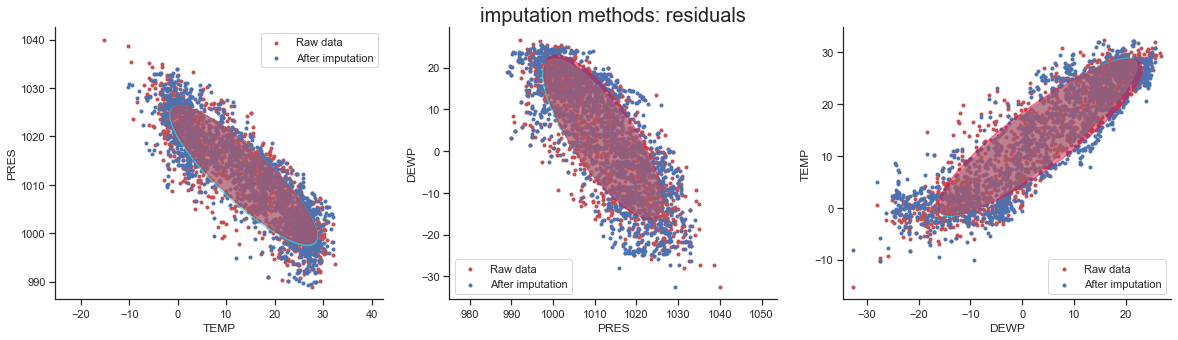

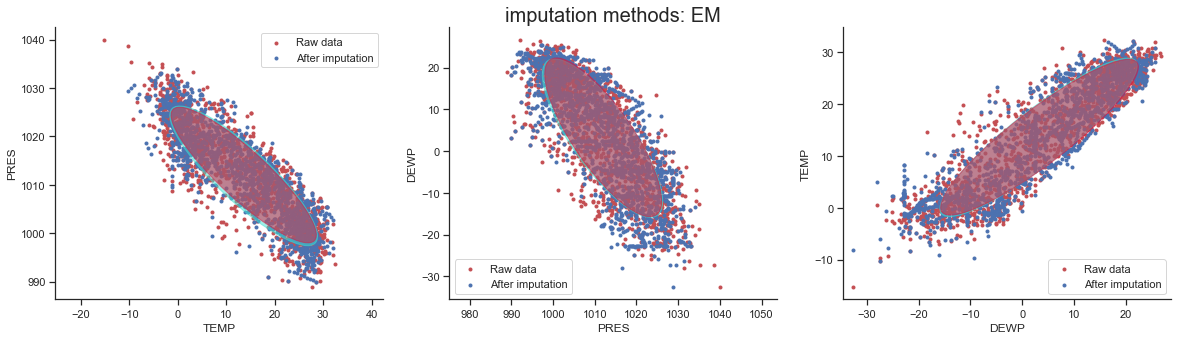

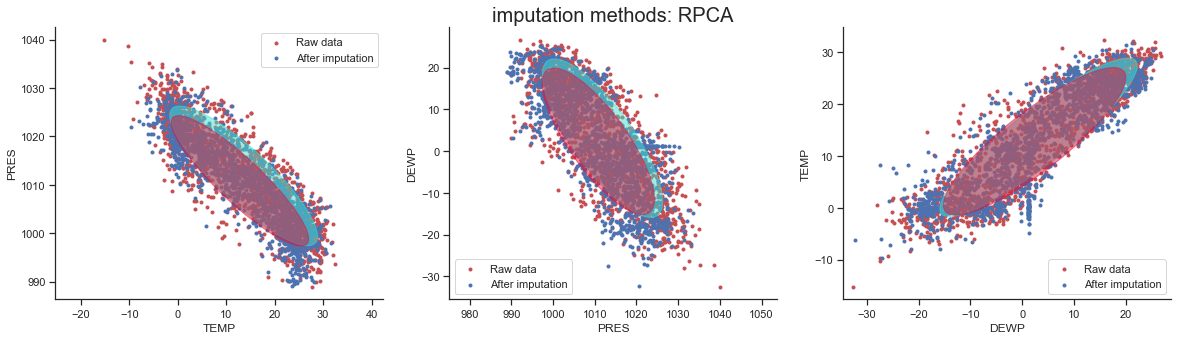

In [89]:
for imputation_method in dict_models.keys():
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    for i in range(3):
        data.compare_covariances(dataset.loc[city, cols_to_impute], dfs_imputed[imputation_method], cols_to_impute[i], cols_to_impute[(i+1)%3], axs[i])
        axs[1].set_title(f"imputation methods: {imputation_method}", fontsize=20)
        sns.despine()
    plt.show()

**IV.b. Coefficient of determination**

Let's look at the coefficient of determination, i.e. $R^2$ regression score function (implemented in sklearn).
Note, however, this coefficient is diffucult to interpret and does not give information about the average error of the imputation model.

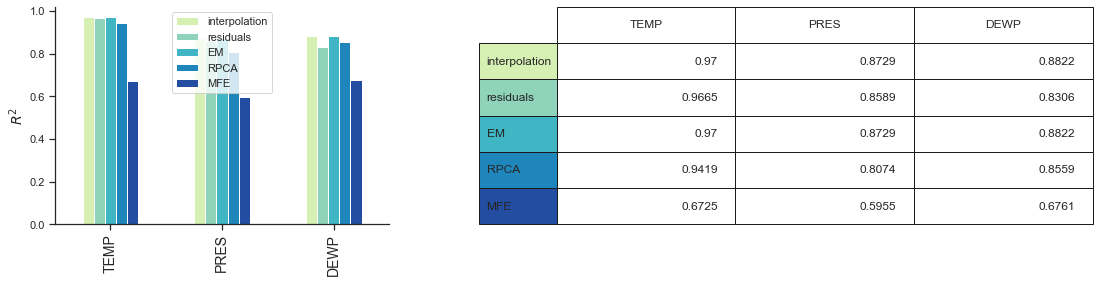

In [229]:
from sklearn.metrics import r2_score

r2_scores = []
for name, df in dfs_imputed.items():
    r2_scores_ = []
    for col in cols_to_impute:
        r2_scores_.append(r2_score(dataset.loc[city, col].dropna(how="all"), df[col].ffill().bfill()))
    r2_scores.append(r2_scores_)
r2_scores = pd.DataFrame(r2_scores, index=dfs_imputed.keys(), columns=cols_to_impute)

display_bar_table(r2_scores, ylabel="$R^2$")

**IV.b. Auto-correlation**

We are now interested in th eauto-correlation function (ACF). As seen before, time series display seaonal patterns.
[Autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) is the correlation of a signal with a delayed copy of itself as a function of delay. Informally, it is the similarity between observations of a random variable as a function of the time lag between them.

The idea is the AFC to be similar between the original dataset and the imputed one.
Fot the TEMP variable, one sees the good reconstruction for all the algorithms. 
On th econtrary, for the PRES variable, all methods overestimates the autocorrelation of the variables, especially the RPCA one. 
Finally, for the DEWP variable, the methods cannot impute to obtain a behavior close to the original: the autocorrelation decreases to linearly. 

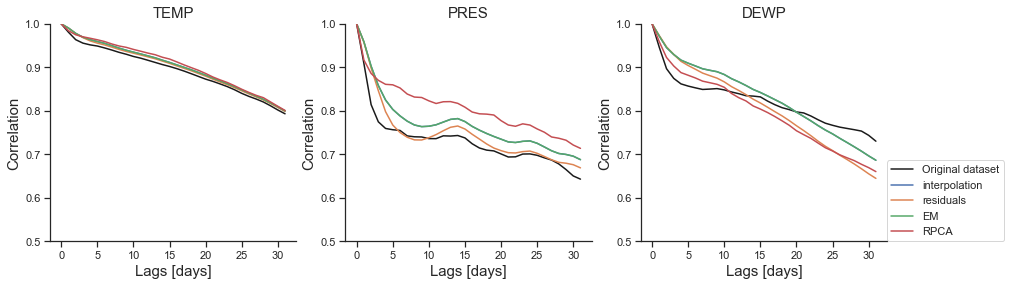

In [167]:
from statsmodels.tsa.stattools import acf
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for i, col in enumerate(cols_to_impute):
    axs[i].plot(acf(dataset.loc[city, col].dropna()), color="k")
    for name, df in dfs_imputed.items():
        axs[i].plot(acf(df[col]))
    axs[i].set_xlabel("Lags [days]", fontsize=15)
    axs[i].set_ylabel("Correlation", fontsize=15)
    axs[i].set_ylim([0.5, 1])
    axs[i].set_title(col, fontsize=15)
axs[-1].legend(["Original dataset"] +  list(dfs_imputed.keys()), loc=[1, 0])
sns.despine()

**IV.b. Distances between distributions**

We are now interested in a way for quantifying the distance between two distributions. 
Until now, we look at the reconstruction error, whatever the distributions. 

There is a plethora of methods to quantify the distance between distributions $P$ and $Q$. 
For instance, those based on the information theory as for instance, the well-known [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence). A simple interpretation of the KL divergence of $P$ from $Q$ is the expected excess surprise from using $Q$ as a model when the actual distribution is $P$.

A drawback with this divergence is it ignores the underlying geometry of the space (the KL divergence is somewhat difficult to intuitively interpret). 
As a remedy, we consider a second metric, the [Wasserstein distance](https://en.wikipedia.org/wiki/Wasserstein_metric), a distance function defined between probability distributions on a given metric space $M$. 

To understand one of the differences between these two quantities, let's take a look at this simple example. 
The KL betwwen the 2 distributions ont the left is the same as the 2 distributions on the right: the KL divergence does not consider the underlying metric space. At variance, the Wasserstein metric is larger for those on the left since the "transport" is bigger.

<p align="center">
    <img src="../../docs/images/test.png"  width=50% height=50%>
</p>


/Users/hlbotterman/virtualEnv/env_qolmat/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning:

invalid value encountered in log



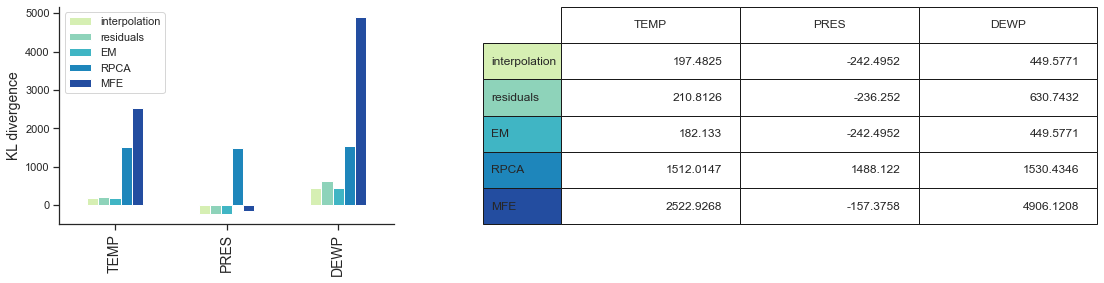

In [230]:
kl_divergences = []
for name, df in dfs_imputed.items():
    kl_divergences_ = []
    for col in cols_to_impute:
        kl_divergences_.append(utils.KL(dataset.loc[city, col].dropna(how="all"), df[col].ffill().bfill()))
    kl_divergences.append(kl_divergences_)
kl_divergences = pd.DataFrame(kl_divergences, index=dfs_imputed.keys(), columns=cols_to_impute)

display_bar_table(kl_divergences, ylabel="KL divergence")

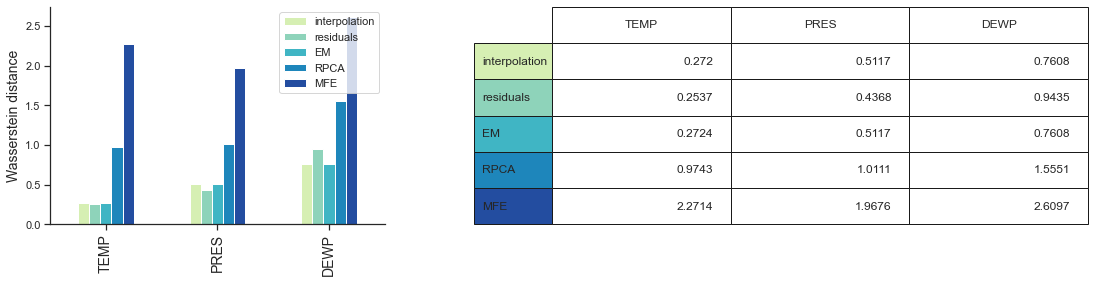

In [231]:
wasserstein = []
for name, df in dfs_imputed.items():
    wasserstein_dist = []
    for col in cols_to_impute:
        wasserstein_dist.append(scipy.stats.wasserstein_distance(dataset.loc[city, col].dropna(how="all"), df[col].ffill().bfill()))
    wasserstein.append(wasserstein_dist)
wasserstein = pd.DataFrame(wasserstein, index=dfs_imputed.keys(), columns=cols_to_impute)

display_bar_table(wasserstein, ylabel="Wasserstein distance")